In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-videos-dataset/youtube.csv


In [2]:
df = pd.read_csv('/kaggle/input/youtube-videos-dataset/youtube.csv')

# 1) Exploratory Data Analysis

In [3]:
df.head()

,link,title,description,category
0,JLZlCZ0,Ep 1| Travelling through North East India | Of...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nT...,travel
1,i9E_Blai8vk,Welcome to Bali | Travel Vlog | Priscilla Lee,Priscilla Lee\n45.6K subscribers\nSUBSCRIBE\n*...,travel
2,r284c-q8oY,My Solo Trip to ALASKA | Cruising From Vancouv...,Allison Anderson\n588K subscribers\nSUBSCRIBE\...,travel
3,Qmi-Xwq-ME,Traveling to the Happiest Country in the World!!,Yes Theory\n6.65M subscribers\nSUBSCRIBE\n*BLA...,travel
4,_lcOX55Ef70,Solo in Paro Bhutan | Tiger's Nest visit | Bhu...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nH...,travel


In [4]:
# See all categories in dataset.
set(df['category'].values.tolist())

{'art_music', 'food', 'history', 'travel'}

In [5]:
# See imbalance.
df['category'].value_counts()

category
travel       1156
art_music     947
food          903
history       593
Name: count, dtype: int64

In [6]:
# See shape for rows. How much total data must be dealt with.
df.shape

(3599, 4)

<Axes: ylabel='count'>

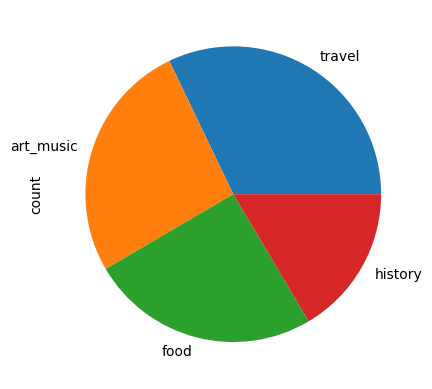

In [7]:
# Visualization helps.
df['category'].value_counts(dropna=False).plot(kind='pie')

# 2) Preprocessing

In [8]:
# Dont need the link column
df.drop('link', axis=1, inplace=True)

df.head()

,title,description,category
0,Ep 1| Travelling through North East India | Of...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nT...,travel
1,Welcome to Bali | Travel Vlog | Priscilla Lee,Priscilla Lee\n45.6K subscribers\nSUBSCRIBE\n*...,travel
2,My Solo Trip to ALASKA | Cruising From Vancouv...,Allison Anderson\n588K subscribers\nSUBSCRIBE\...,travel
3,Traveling to the Happiest Country in the World!!,Yes Theory\n6.65M subscribers\nSUBSCRIBE\n*BLA...,travel
4,Solo in Paro Bhutan | Tiger's Nest visit | Bhu...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nH...,travel


### 2.2) Lowercase

In [9]:
''' Lets lowercase all the words. Do same for title because title obviously contains words and maybe
    combining that with the description will help later models be more accurate. '''

df['title'] = df['title'].map(lambda x: x.lower())
df['description'] = df['description'].map(lambda x: x.lower())

df.head()

,title,description,category
0,ep 1| travelling through north east india | of...,tanya khanijow\n671k subscribers\nsubscribe\nt...,travel
1,welcome to bali | travel vlog | priscilla lee,priscilla lee\n45.6k subscribers\nsubscribe\n*...,travel
2,my solo trip to alaska | cruising from vancouv...,allison anderson\n588k subscribers\nsubscribe\...,travel
3,traveling to the happiest country in the world!!,yes theory\n6.65m subscribers\nsubscribe\n*bla...,travel
4,solo in paro bhutan | tiger's nest visit | bhu...,tanya khanijow\n671k subscribers\nsubscribe\nh...,travel


### 2.3) Removing urls

In [10]:
import re

''' To make this process easy, regex will be used. Very useful for nlp because it allows us to mess with text somewhat 
    simply Removing urls now is vital because removing special characters will be done. Why does order matter? 
    If remove specials first, then "http://seek-discomfort.com/yes-theory" would be "httpseekdiscomfort.comyestheory"
    and thats a mess. This is from #4 (index 3) in the dataset which is:
    
        ""yes theory\n6.65m subscribers\nsubscribe\n*black friday drop out now*: http://seek-discomfort.com/yes-theory \n
        this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!\n\ncheck out our friends 
        from beautiful destinations!! their videos are incredible:\nshow more""
         
    Also simplier links such as index 16 that has " 'emma rose\n120k subscribers\nsubscribe\nfollow along a travel 
    day in my life!! \n\nlinks:\nluggage: www.away.com \n\nsocial\nig @emmaleger\n\nftc this video is not sponsored.
    \nshow more'". Removing special characters would result in wwwawaycom. That further complicates the text. So 
    remove urls FIRST, then special characters.
    
    How does it work?
        1) https? - Finds both http and https
        2) // - Part of a typical url.
        3) \S - Matches all non space characters that could be present. 
        4) + - Literally like saying "okay do what was just done and THEN do whatever comes after this plus sign"
        5) | - The or operator. The "https?://\S+" searched for a specific format of a url. But after "|" comes a different
                pattern. A simplier one in my opinion.
        6) \. - Just find a period '''

reg_pattern = re.compile(r'https?://\S+|www\.\S+')

def remove_urls(sent, display=False):
    if display is True:
        print(f'Sentence as passed to function:\n{sent}\n')
        
    found_urls = reg_pattern.findall(sent)
    for url in found_urls:
        sent = sent.replace(url, '')
    
    if display is True:
        print(f'NEW sentence:\n{sent}\n')
    
    return sent
    

print(remove_urls(df['description'][3], True))
print('\n')
print(remove_urls(df['description'][16], True))

Sentence as passed to function:
yes theory
6.65m subscribers
subscribe
*black friday drop out now*: http://seek-discomfort.com/yes-theory 
this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!

check out our friends from beautiful destinations!! their videos are incredible:
show more

NEW sentence:
yes theory
6.65m subscribers
subscribe
*black friday drop out now*:  
this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!

check out our friends from beautiful destinations!! their videos are incredible:
show more

yes theory
6.65m subscribers
subscribe
*black friday drop out now*:  
this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!

check out our friends from beautiful destinations!! their videos are incredible:
show more


Sentence as passed to function:
emma rose
120k subscribers
subscribe
follow along a travel day in my life!! 

links:
luggage: www.away.com 

social
ig @emmaleger



In [11]:
# Use on both columns
df['title'] = df['title'].map(remove_urls)
df['description'] = df['description'].map(remove_urls)

df.head()

,title,description,category
0,ep 1| travelling through north east india | of...,tanya khanijow\n671k subscribers\nsubscribe\nt...,travel
1,welcome to bali | travel vlog | priscilla lee,priscilla lee\n45.6k subscribers\nsubscribe\n*...,travel
2,my solo trip to alaska | cruising from vancouv...,allison anderson\n588k subscribers\nsubscribe\...,travel
3,traveling to the happiest country in the world!!,yes theory\n6.65m subscribers\nsubscribe\n*bla...,travel
4,solo in paro bhutan | tiger's nest visit | bhu...,tanya khanijow\n671k subscribers\nsubscribe\nh...,travel


In [12]:
# Recheck index 3 and 16 because they were the example texts that had urls
print(df['description'][3])
print('\n\n\n')
print(df['description'][16])

yes theory
6.65m subscribers
subscribe
*black friday drop out now*:  
this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!

check out our friends from beautiful destinations!! their videos are incredible:
show more




emma rose
120k subscribers
subscribe
follow along a travel day in my life!! 

links:
luggage:  

social
ig @emmaleger

ftc this video is not sponsored.
show more


### 2.4) Removing new line characters

In [13]:
''' Newlines don't matter so remove them, especially BEFORE removing special characters. Can be 
    done with a simple replace. Example below. '''

df['description'][16], df['description'][16].replace('\n', ' ')

('emma rose\n120k subscribers\nsubscribe\nfollow along a travel day in my life!! \n\nlinks:\nluggage:  \n\nsocial\nig @emmaleger\n\nftc this video is not sponsored.\nshow more',
 'emma rose 120k subscribers subscribe follow along a travel day in my life!!   links: luggage:    social ig @emmaleger  ftc this video is not sponsored. show more')

In [14]:
# Remove them all
df['title'] = df['title'].map(lambda x: x.replace('\n', ' '))
df['description'] = df['description'].map(lambda x: x.replace('\n', ' '))

# display example at index 16 again, and 3 (seen in the removing urls section) for good measure.

df['description'][16], df['description'][3]

('emma rose 120k subscribers subscribe follow along a travel day in my life!!   links: luggage:    social ig @emmaleger  ftc this video is not sponsored. show more',
 "yes theory 6.65m subscribers subscribe *black friday drop out now*:   this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!  check out our friends from beautiful destinations!! their videos are incredible: show more")

### 2.5) Removing spaces

In [15]:
''' It can't just be me but extra spaces annoy me. They trigger my ocd simply by existing, therefore they must be destroyed.
    Normally .strip() is used for space removal but that won't apply here because it only removes the leading (beginning)
    and trailing (ending) whitespaces as displayed in the example code below. '''

test_str = '   Hi there,   this        is a string!  '

test_str.strip()

'Hi there,   this        is a string!'

In [16]:
# Instead use the combo of .split which turns the string into a list and then join which brings it back together.
x =  df['description'][3]
y = ' '.join(x.split())

print(f'Example string:\n{x}\n\nPost excess space removal:\n{y}')

Example string:
yes theory 6.65m subscribers subscribe *black friday drop out now*:   this week only, with every purchase about $35, you'll get 2 free seek discomfort flags!  check out our friends from beautiful destinations!! their videos are incredible: show more

Post excess space removal:
yes theory 6.65m subscribers subscribe *black friday drop out now*: this week only, with every purchase about $35, you'll get 2 free seek discomfort flags! check out our friends from beautiful destinations!! their videos are incredible: show more


In [17]:
df['title'] = df['title'].map(lambda x: ' '.join(x.split()))
df['description'] = df['description'].map(lambda x: ' '.join(x.split()))

# Extra spaces in the middle now gone.
df['description'][16], df['description'][3]

('emma rose 120k subscribers subscribe follow along a travel day in my life!! links: luggage: social ig @emmaleger ftc this video is not sponsored. show more',
 "yes theory 6.65m subscribers subscribe *black friday drop out now*: this week only, with every purchase about $35, you'll get 2 free seek discomfort flags! check out our friends from beautiful destinations!! their videos are incredible: show more")

### 2.6) Removing emails

In [18]:
''' Out of curiosity how many other rows have emails? Findout using the df[df[]] approach which
    can filter the df. Since we're concerned about strings, access the str column of decription
    and check if each contains the @ which confirms an email.
    
    Not necessary but reset the index to not see the out of order indices that WOULD be displayed. 
    drop=True because no need to have that column of indices as well.
    
    !!! Important !!! 
        Also bare in mind that @ is the main thing in twitter handles as well which will be removed in a
        different way. The regex used simply says "start searching for @, then any characters inbetween
        (most likely gmail but can be yahoo, etc), count those as well because we have a-z for all lowercase
        characters and A-Z (likely unnecessary but just to be safe) as well. Finally make sure it has .com
        at the end." LATER, .net will be searched for '''

email_df = df[df['description'].str.contains("@+[a-zA-Z]+.com")].reset_index(drop=True)

email_df

,title,description,category
0,200 days - a trip around the world travel film,40 north designs 20.5k subscribers subscribe m...,travel
1,international travel blogs,jeet vlogs 49 subscribers subscribe my interna...,travel
2,piyush bach gaya 😂,sourav joshi vlogs 5.21m subscribers subscribe...,travel
3,it was a task 💉 | ss vlogs :-),sambhavna seth entertainment 1.9m subscribers ...,travel
4,our new fridge is here !! 😍🔥,ypm vlogs 1.26m subscribers subscribe ▶ for bu...,travel
...,...,...,...
85,hindi songs 2021 - bollywood songs 2021 - old ...,bollywood romantic songs subscribe hindi songs...,art_music
86,dulhan hum le jayenge all songs jukebox | salm...,indian music subscribe click here to subscribe...,art_music
87,indian history of bhagat singh | ypss,team ypss - pb 199k subscribers subscribe ypss...,history
88,real china history,kaheva universe 303k subscribers subscribe ins...,history


In [19]:
''' How many of those are gmail? Find out by searching the df with the "df[df[]]" convention. 
    Access the description column of course, and see if the string or text literally contains 
    gmail. '''

print(email_df.shape)

# So only 81 out of the 90 are gmail.
email_df[email_df['description'].str.contains("gmail")].shape

(90, 3)


(81, 3)

In [20]:
''' Out of curiosity, lets see what exists besides gmail. To "negate" the search for it the dataframe strings do 
    contain something, just put False as a comparison.'''
no_gmail_df = email_df[email_df['description'].str.contains("gmail") == False]

# A HOTMAIL email is there! Hotmail STILL exists. This is incredible.
for i, x in enumerate(no_gmail_df['description']):
    print(f'{i+1}) Index {i}---\n{x}\n\n')

1) Index 0---
sourav joshi vlogs 5.21m subscribers subscribe follow me on instagram- ( for collaboration - saurav@impelentertainment.com and impel entertainment team will get in touch with you. ) i hope you enjoyed this video hit likes. and do subscribe to my channel thank you so much for watching god bless you all. lots of ❤️ my vlogging setup- canon powershot g7 x mark ii- show more


2) Index 1---
allie auton 87.3k subscribers subscribe hello my loves, here is a little vlog from the girls and i's trip to bali last week! it's a little long but i hope you guys don't mind :) let me know in the comments what other video's you'd like to see/if you have any questions! accomodation: villa kubu - seminyak villa plawa - seminyak canggu village - canggu instagram: @allieeauton contact: allieautonfitness@hotmail.com featuring: @rhiannondarney, @madiwoolley & @lexieemurray thanks again for watching! allie xx show more


3) Index 2---
millie windebank 28.4k subscribers subscribe wow, i’m so happ

In [21]:
''' Attempt removing the above emails that aren't gmail. This is done because I'd like to see it fully functional BEFORE
    I apply it to the entire regular dataframe, CALLED df. 
    
    The regex is a lot simpler than it looks. 
        1) [] - Square brackets give characters you want to match.
        2) \w - Find any of the following: [a-zA-Z0-9_]
        3) \. - Find a period
        4) \- - Find a dash
        5) \_ - find an underscore
        6) + - As said before this says "Literally like saying "okay do what was just done and THEN do whatever 
                comes after this plus sign" "
        7) @ - Of course the "at" sign for emails.
    '''

result_series = no_gmail_df['description'].map(lambda x: re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", "", x))

for i, x in enumerate(result_series):
    print(f'{i+1}) Index {i}---\n{x}\n\n')

1) Index 0---
sourav joshi vlogs 5.21m subscribers subscribe follow me on instagram- ( for collaboration -  and impel entertainment team will get in touch with you. ) i hope you enjoyed this video hit likes. and do subscribe to my channel thank you so much for watching god bless you all. lots of ❤️ my vlogging setup- canon powershot g7 x mark ii- show more


2) Index 1---
allie auton 87.3k subscribers subscribe hello my loves, here is a little vlog from the girls and i's trip to bali last week! it's a little long but i hope you guys don't mind :) let me know in the comments what other video's you'd like to see/if you have any questions! accomodation: villa kubu - seminyak villa plawa - seminyak canggu village - canggu instagram: @allieeauton contact:  featuring: @rhiannondarney, @madiwoolley & @lexieemurray thanks again for watching! allie xx show more


3) Index 2---
millie windebank 28.4k subscribers subscribe wow, i’m so happy i have finally finished editing this video haha it took 

In [22]:
# Test regex on the gmail dataframe too but save it this time
gmail_df = email_df[email_df['description'].str.contains("gmail")]

# Same process to remove emails. \s here for one space as well.
gmail_series = gmail_df['description'].map(lambda x: re.sub("([\w\.\-\_]+@[\w\.\-\_]+\s)", "", x))

# There's a lot more of these, so only print a few.
total_to_print = 10
gmail_present = gmail_df['description'].values.tolist()[:total_to_print]
gmail_removed = gmail_series.values.tolist()[:total_to_print]

for i in range(total_to_print):
    print(f'-----Index {i}-----\n--1) WITH gmail:\n{gmail_present[i]}\n\n--2) Gmail removed:\n{gmail_removed[i]}\n\n\n')

-----Index 0-----
--1) WITH gmail:
40 north designs 20.5k subscribers subscribe my wife and i traveled to 17 countries in 200 days. this film is the story of our incredible trip! enjoy! we used a gopro and a nikon d7000 for all of the filming. for business inquiries please e.mail me at 40northdesigns@gmail.com. website: 40northdesigns.com music credits: please check out and buy the music from these incredible artists that made this film possible. they are in order of appearance. m83 - outro show more

--2) Gmail removed:
40 north designs 20.5k subscribers subscribe my wife and i traveled to 17 countries in 200 days. this film is the story of our incredible trip! enjoy! we used a gopro and a nikon d7000 for all of the filming. for business inquiries please e.mail me at website: 40northdesigns.com music credits: please check out and buy the music from these incredible artists that made this film possible. they are in order of appearance. m83 - outro show more



-----Index 1-----
--1) WI

In [23]:
''' Code like this used before. Filter the df by email and reset_index gets the column of old indices put INTO it.
    Then access the index column and get the values to the list. I will keep record of some indices and then
    display them again to see the process of removing emails is complete. '''

indices = df[df['description'].str.contains("@+[a-zA-Z]+.com")].reset_index()['index'].values.tolist()

print(len(indices)) 
print(indices[:3])
print('\n')

for i in indices[:3]:
    cur_string = df['description'][i]
    print(f'-----Index {i}-----\n{cur_string}\n\n\n')

90
[163, 187, 243]


-----Index 163-----
40 north designs 20.5k subscribers subscribe my wife and i traveled to 17 countries in 200 days. this film is the story of our incredible trip! enjoy! we used a gopro and a nikon d7000 for all of the filming. for business inquiries please e.mail me at 40northdesigns@gmail.com. website: 40northdesigns.com music credits: please check out and buy the music from these incredible artists that made this film possible. they are in order of appearance. m83 - outro show more



-----Index 187-----
jeet vlogs 49 subscribers subscribe my international travel blog.please like subscribe & share. my instagram - mr_singh1235 facebook - singh.charanjeet777@gmail.com show more



-----Index 243-----
sourav joshi vlogs 5.21m subscribers subscribe follow me on instagram- ( for collaboration - saurav@impelentertainment.com and impel entertainment team will get in touch with you. ) i hope you enjoyed this video hit likes. and do subscribe to my channel thank you so 

In [24]:
# Remove the emails
df['description'] = df['description'].map(lambda x: re.sub("([\w\.\-\_]+@[\w\.\-\_]+\s)", "", x))

In [25]:
# View the indices in dataframe that used to have them.
for i in indices[:3]:
    cur_string = df['description'][i]
    print(f'-----Index {i}-----\n{cur_string}\n\n\n')

-----Index 163-----
40 north designs 20.5k subscribers subscribe my wife and i traveled to 17 countries in 200 days. this film is the story of our incredible trip! enjoy! we used a gopro and a nikon d7000 for all of the filming. for business inquiries please e.mail me at website: 40northdesigns.com music credits: please check out and buy the music from these incredible artists that made this film possible. they are in order of appearance. m83 - outro show more



-----Index 187-----
jeet vlogs 49 subscribers subscribe my international travel blog.please like subscribe & share. my instagram - mr_singh1235 facebook - show more



-----Index 243-----
sourav joshi vlogs 5.21m subscribers subscribe follow me on instagram- ( for collaboration - and impel entertainment team will get in touch with you. ) i hope you enjoyed this video hit likes. and do subscribe to my channel thank you so much for watching god bless you all. lots of ❤️ my vlogging setup- canon powershot g7 x mark ii- show more


### 2.7) Removing twitter handles

In [26]:
# These are present in the dataset.

social_str = df['description'][16]

non_social_str = re.sub('@+[a-zA-Z0-9]+\s', '', social_str)

print(f'String WITH @ handle in it:\n{social_str}\n\nString WITHOUT @ handle in it:\n{non_social_str}')

String WITH @ handle in it:
emma rose 120k subscribers subscribe follow along a travel day in my life!! links: luggage: social ig @emmaleger ftc this video is not sponsored. show more

String WITHOUT @ handle in it:
emma rose 120k subscribers subscribe follow along a travel day in my life!! links: luggage: social ig ftc this video is not sponsored. show more


In [27]:
# Just like emails, I'm curious regarding how many rows have twitter handles.

handle_df = df[df['description'].str.contains("@")].reset_index(drop=True)

handle_df

,title,description,category
0,"travel day vlog: airport essentials, what's in...",emma rose 120k subscribers subscribe follow al...,travel
1,los angeles travel vlog | top things to do in la,danya h 6.63k subscribers subscribe my first t...,travel
2,get to know us | femi & envor | travel my blog...,travel my blog 185 subscribers subscribe hello...,travel
3,bhai (@traveling desi) ne demand ki hai...poor...,chatty and scatty 220k subscribers subscribe f...,travel
4,bali on a budget (exotic villa tour),brett conti 315k subscribers subscribe where t...,travel
...,...,...,...
92,chinese makeup routines through the dynasties,off the great wall 754k subscribers subscribe ...,history
93,superpower interrupted: the chinese history of...,new america 18.1k subscribers subscribe we in ...,history
94,chinese hairstyles through the dynasties,off the great wall 754k subscribers subscribe ...,history
95,chinese history in 5 minutes | literature,"culture click 139 subscribers subscribe hi, we...",history


In [28]:
# Just like in removing emails, get the real indices of the handles and save them to view those indices after removing twitter handles.
handle_indices = df[df['description'].str.contains('@')].reset_index()['index'].values.tolist()

print(len(handle_indices))
print(handle_indices[:3])
print('\n')

for index in handle_indices[:3]:
    cur_string = df['description'][index]
    print(f'-----Index {index}-----\n{cur_string}\n\n\n')

97
[16, 84, 104]


-----Index 16-----
emma rose 120k subscribers subscribe follow along a travel day in my life!! links: luggage: social ig @emmaleger ftc this video is not sponsored. show more



-----Index 84-----
danya h 6.63k subscribers subscribe my first time exploring la and i am so excited to share it with you guys! i tried to hit up all the touristy and instagrammable spots in la and had so much fun exploring the beautiful city with my bestfriend. hope you guys enjoy it and please give it a thumbs up if you do ♡♡♡ subscribe for new weekly videos! see you next week! - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - let’s be friends!!! instagram: @thedesertcarnation / @stylewithdanya facebook: @thedesertcarnation blog website: show more



-----Index 104-----
travel my blog 185 subscribers subscribe hello! we are femi & envor from south africa. welcome to travel my blog! travel my blog is a travel blog filled with practical travel 

In [29]:
# Remove twitter handles
df['description'] = df['description'].map(lambda x: re.sub("@+[a-zA-Z0-9]+\s", "", x))

In [30]:
# Loop through indices to check if it took effect and it did.
for index in handle_indices[:3]:
    cur_string = df['description'][index]
    print(f'-----Index {index}-----\n{cur_string}\n\n\n')

-----Index 16-----
emma rose 120k subscribers subscribe follow along a travel day in my life!! links: luggage: social ig ftc this video is not sponsored. show more



-----Index 84-----
danya h 6.63k subscribers subscribe my first time exploring la and i am so excited to share it with you guys! i tried to hit up all the touristy and instagrammable spots in la and had so much fun exploring the beautiful city with my bestfriend. hope you guys enjoy it and please give it a thumbs up if you do ♡♡♡ subscribe for new weekly videos! see you next week! - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - let’s be friends!!! instagram: / facebook: blog website: show more



-----Index 104-----
travel my blog 185 subscribers subscribe hello! we are femi & envor from south africa. welcome to travel my blog! travel my blog is a travel blog filled with practical travel tips and adventures from south africa and around the globe. based on personal travels 

In [31]:
# Same process for the title. Show the sub df with shape and then get the indices to display after removing
title_df = df[df['title'].str.contains('@+[a-zA-Z0-9]+\s')]

print(title_df.shape)
print('\n')

title_indices = title_df.reset_index()['index'].values.tolist()
print(len(title_indices))
print(title_indices[:3])
print('\n')

for index in title_indices[:3]:
    cur_string = df['title'][index]
    print(f'-----Index {index}-----\n{cur_string}\n\n')

(11, 3)


11
[50, 213, 621]


-----Index 50-----
top 10 travel vloggers in india | july 2020 | ft. @nomadic indian @mithilesh backpacker and more..


-----Index 213-----
bhai (@traveling desi) ne demand ki hai...poori toh karni padegi


-----Index 621-----
the golden temple -amritsar sahib | ਹਰਿਮੰਦਰ ਸਾਹਿਬ | punjabi vlogs | @singh in germany




In [32]:
df['title'] = df['title'].map(lambda x: re.sub("@+[a-zA-Z0-9]+\s", "", x))

In [33]:
for index in title_indices[:3]:
    cur_string = df['title'][index]
    print(f'-----Index {index}-----\n{cur_string}\n\n')

-----Index 50-----
top 10 travel vloggers in india | july 2020 | ft. indian backpacker and more..


-----Index 213-----
bhai (desi) ne demand ki hai...poori toh karni padegi


-----Index 621-----
the golden temple -amritsar sahib | ਹਰਿਮੰਦਰ ਸਾਹਿਬ | punjabi vlogs | in germany




### 2.8) Investigating hashtags

In [34]:
# Regex will search for numbers as well, and do the same for title
hashtag_desc_df = df[df['description'].str.contains('#+[a-zA-Z0-9]+\s')]
print(f'DESCRIPTION Dataframe with hashtags:\n{hashtag_desc_df.head()}\n\n')

# Out of the entire df only THREE in the title have hashtags. I found that kinda weird but of course it's possible.
hashtag_title_df = df[df['title'].str.contains('#+[a-zA-Z0-9]+\s')]
print(f'TITLE Dataframe with hashtags:\n{hashtag_title_df.head()}\n\n\n\n')
# title_len = hashtag_title_df.shape[0]



# Get the indices for both desc and title and do the usual comparisons
hashtag_desc_indices = hashtag_desc_df.reset_index()['index'].values.tolist()
hashtag_title_indices = hashtag_title_df.reset_index()['index'].values.tolist()

print(f'Desc indices: {hashtag_desc_indices[:total_to_print]}')
print(f'Title indices: {hashtag_title_indices[:total_to_print]}\n\n\n')



# Drop the old indices now since they're no longer needed. Inplace makes sure it won't return a new df but does it in the current one.
hashtag_desc_df.reset_index(drop=True, inplace=True)
hashtag_title_df.reset_index(drop=True, inplace=True)



# Loop over a few and display the description values.
border = '-' * 30
print(f'{border}Hashtag decription and title text in detail below{border}\n\n')


''' !!! Important !!!

    As seen below, a lot of these hashtags make sense to humans. Some can relate to the topic/label that is in the dataframe.
    Index 0 in descriptions df has "#indianinegypt".
    Index 4 in descriptions df has "#kolkata" which is a city in india.
    Index 9 in descriptions df has "#hometourblog", "#hometourvlog"
    
    Index 6 in title df has "#travel"
    
    Again, some of these can indicate what the text is about for predictions. However to be able to accurately break up hashtags,
    that can literally be the sum of any words and nonsensical text (Ex: #JFKAnniversaryShooting, #bestwestcoasttacos, etc) seems
    not really possible for the models to understand. That's why I have decided to remove them. '''

for i in range(total_to_print):
    cur_text = hashtag_desc_df['description'][i]
    print(f'-----{i+1}) Index {i} in DESCRIPTIONS df-----\n{cur_text}\n')
print('\n\n\n')

for i in range(total_to_print):
    cur_text = hashtag_title_df['title'][i]
    print(f'-----{i+1}) Index {i} in TITLE df-----\n{cur_text}\n')

DESCRIPTION Dataframe with hashtags:
                                                 title  \
27   egypt : how people treat an indian tourist 😡 #...   
52   tour to purulia leprosy mission with every det...   
75   top 10 travel vloggers in kerala | kerala yout...   
133  short travel blogs || #aestheticsong #status #...   
147  exploring kolkata 2020 || budget trip || trave...   

                                           description category  
27   indian backpacker 960k subscribers subscribe e...   travel  
52   #dipanjan gbp (grand blogging platform) 24 sub...   travel  
75   techtravel blog subscribe #vloggers #kerala th...   travel  
133  sheikh nahiyan 6 subscribers subscribe #raanjh...   travel  
147  navin backpacker subscribe exploring the whole...   travel  


TITLE Dataframe with hashtags:
                                                title  \
22  gulmarg, kashmir during snowfall! jannat in in...   
27  egypt : how people treat an indian tourist 😡 #...   
28  sikkim tra

In [35]:
# Remove hashtags from description and title.
df['description'] = df['description'].map(lambda x: re.sub('#+[a-zA-Z0-9]+\s', '', x))
df['title'] = df['title'].map(lambda x: re.sub('#+[a-zA-Z0-9]+\s', '', x))

In [36]:
# Check the indices as we usually do.
print(f'Indices in description that used to have hashtags: {hashtag_desc_indices[:total_to_print]}')
print(f'Indices in title that used to have hashtags: {hashtag_desc_indices[:total_to_print]}\n\n')

for i in hashtag_desc_indices[:10]:
    cur_text = df['description'][i]
    print(f'-----{i+1}) Index {i} in df, DESCRIPTIONS column-----\n{cur_text}\n')
    
print('\n\n')

for i in hashtag_title_indices[:10]:
    cur_text = df['title'][i]
    print(f'-----{i+1}) Index {i} in df, TITLE column-----\n{cur_text}\n')

Indices in description that used to have hashtags: [27, 52, 75, 133, 147, 160, 191, 198, 209, 222]
Indices in title that used to have hashtags: [27, 52, 75, 133, 147, 160, 191, 198, 209, 222]


-----28) Index 27 in df, DESCRIPTIONS column-----
indian backpacker 960k subscribers subscribe egypt : how people treat an indian tourist 😡 |ep-10|. instagram : show more

-----53) Index 52 in df, DESCRIPTIONS column-----
gbp (grand blogging platform) 24 subscribers subscribe welcome to my description box if you loved it then share it to everyone. this is very amazing tour .

-----76) Index 75 in df, DESCRIPTIONS column-----
techtravel blog subscribe these video includes my favorite top 10 travel vloggers in kerala. so vloggers should include tech travel eat by sujith bhakthan,harees ameerali,food n travel by ebbin jose,abhijith vlogger....etc please watch the video for all channel details and subscribe by channel...! show more

-----134) Index 133 in df, DESCRIPTIONS column-----
sheikh nahiyan 

### 2.9) Special characters

In [37]:
# Now removing special chars. More seen in the title column/feature.
df.head(20)

,title,description,category
0,ep 1| travelling through north east india | of...,tanya khanijow 671k subscribers subscribe the ...,travel
1,welcome to bali | travel vlog | priscilla lee,priscilla lee 45.6k subscribers subscribe *dis...,travel
2,my solo trip to alaska | cruising from vancouv...,allison anderson 588k subscribers subscribe i ...,travel
3,traveling to the happiest country in the world!!,yes theory 6.65m subscribers subscribe *black ...,travel
4,solo in paro bhutan | tiger's nest visit | bhu...,tanya khanijow 671k subscribers subscribe here...,travel
5,koh phangan: 'new thailand' for indian family ...,mountain trekker 1.42m subscribers join subscr...,travel
6,amazing kerala story | why i went rainforest a...,xtreme moto adventure 800k subscribers join su...,travel
7,ep 14 meghalaya tour complete travel guide | n...,visa2explore 1.21m subscribers join subscribe ...,travel
8,summer vacation in ladakh | 6 day itinerary | ...,garima's good life 1.76m subscribers subscribe...,travel
9,"kerala's best beaches in varkala! cliff cafes,...",tanya khanijow 671k subscribers subscribe kera...,travel


In [38]:
''' In more detail. With zip, a range can be given for the endpoint like a regular "for i in range(num_here)" loop.
    The range value will be in "i". The "text" will be a list of both the current title AND description together. '''

for i in range(5):
    title = df['title'][i]
    text = df['description'][i]
    print(f'----------Index {i} in df----------\n- Title: {title}\n- Text: {text}\n\n')

----------Index 0 in df----------
- Title: ep 1| travelling through north east india | off to arunachal | the journey begins | pasighat
- Text: tanya khanijow 671k subscribers subscribe the journey to arunachal, north east india begins with a train journey from guwahati to murkongselek. from here we head to pasighat. and i and my travel companions are just getting started by exploring the tiny glimpse of arunachal that we have so far. from markets to bridges, the adventure will only get better from here. :) next video: show more


----------Index 1 in df----------
- Title: welcome to bali | travel vlog | priscilla lee
- Text: priscilla lee 45.6k subscribers subscribe *disclaimer* please do not ride elephants when visiting any country. at the time i didn't know (yes, i was dumb) so it is shown in the video, but i do not support the elephant riding business anymore. if i could take it back i would, but instead i want to pass on the knowledge to anyone who isn't aware. here's some info: s

In [39]:
import string

''' String has common punctuation that likely are present in the text. Models won't need it. Specifically 
    string.punctuation holds "'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'". I mentioned in the remove urls section 
    that "*black friday drop out now*" in the description in index 3 of the dataframe had to be taken care
    of. With this, it definitely will.
    
        !!! Important !!!
        The result shows several numbers still in the text which are 665m, 35, and 2. These will be handled
        soon so no worries. '''

def filter_out_special_chars(text):
    return ''.join([cur_char for cur_char in text if cur_char not in string.punctuation])

x = df['description'][3]
print(f'Example string:\n{x}\n\n')

print(f'Post special char removal example string:\n{filter_out_special_chars(x)}')

Example string:
yes theory 6.65m subscribers subscribe *black friday drop out now*: this week only, with every purchase about $35, you'll get 2 free seek discomfort flags! check out our friends from beautiful destinations!! their videos are incredible: show more


Post special char removal example string:
yes theory 665m subscribers subscribe black friday drop out now this week only with every purchase about 35 youll get 2 free seek discomfort flags check out our friends from beautiful destinations their videos are incredible show more


In [40]:
df['title'] = df['title'].map(filter_out_special_chars)
df['description'] = df['description'].map(filter_out_special_chars)

df.head()

,title,description,category
0,ep 1 travelling through north east india off ...,tanya khanijow 671k subscribers subscribe the ...,travel
1,welcome to bali travel vlog priscilla lee,priscilla lee 456k subscribers subscribe discl...,travel
2,my solo trip to alaska cruising from vancouve...,allison anderson 588k subscribers subscribe i ...,travel
3,traveling to the happiest country in the world,yes theory 665m subscribers subscribe black fr...,travel
4,solo in paro bhutan tigers nest visit bhutan...,tanya khanijow 671k subscribers subscribe here...,travel


### 2.9.2) Numbers

In [41]:
from nltk.tokenize import word_tokenize

''' Remember the example string a few cells ago. The one used in the cell with the "filter_out_special_chars" function declaration which was:
    "yes theory 6.65m subscribers subscribe *black friday drop out now*: this week only, with every purchase about $35, you'll get 2 free seek 
    discomfort flags! check out our friends from beautiful destinations!! their videos are incredible: show more"

    It has various numbers. 665m. 35, and 2. In fact now almost all text most likely has the #m/M or #k/K at the end because the data showed 
    how many subscribers a YouTuber had. All of these were technically altered when special characters were removed because "." was removed as 
    well. The example below WAS 6.65m. But regardless whether its 6.65m/k, 665m/k, it'll be removed now. '''

x = df['description'][3]

def remove_numbers(text):
    tokenized_text = word_tokenize(text)
    return ' '.join([token for token in tokenized_text if token.isalpha()])

print(f'Original string:\n{x}\n\nString with no numbers:\n{remove_numbers(x)}')

Original string:
yes theory 665m subscribers subscribe black friday drop out now this week only with every purchase about 35 youll get 2 free seek discomfort flags check out our friends from beautiful destinations their videos are incredible show more

String with no numbers:
yes theory subscribers subscribe black friday drop out now this week only with every purchase about youll get free seek discomfort flags check out our friends from beautiful destinations their videos are incredible show more


In [42]:
# Apply to both title and description
df['title'] = df['title'].map(remove_numbers)
df['description'] = df['description'].map(remove_numbers)

''' Show 20 just like before because I seen more title rows with numbers in them. Ex: Row 13 had "switzerland in rs. 75,000 - 10 days 
    10 cities ..." and after applying the function, the numbers are now gone. '''
df.head(20)

,title,description,category
0,ep travelling through north east india off to ...,tanya khanijow subscribers subscribe the journ...,travel
1,welcome to bali travel vlog priscilla lee,priscilla lee subscribers subscribe disclaimer...,travel
2,my solo trip to alaska cruising from vancouver...,allison anderson subscribers subscribe i spent...,travel
3,traveling to the happiest country in the world,yes theory subscribers subscribe black friday ...,travel
4,solo in paro bhutan tigers nest visit bhutan t...,tanya khanijow subscribers subscribe here s pr...,travel
5,koh phangan new thailand for indian family and...,mountain trekker subscribers join subscribe th...,travel
6,amazing kerala story why i went rainforest ath...,xtreme moto adventure subscribers join subscri...,travel
7,ep meghalaya tour complete travel guide north ...,subscribers join subscribe how to plan your jo...,travel
8,summer vacation in ladakh day itinerary pangon...,garimas good life subscribers subscribe do wat...,travel
9,keralas best beaches in varkala cliff cafes se...,tanya khanijow subscribers subscribe kerala is...,travel


### 2.9.3) Subscribers

In [43]:
''' A majority of the text has "subscribers subscribe", "subscribers join subscribe", or even "subscribers
    subscribe join". This is a YouTube dataset. Saying "subscribe" in multiple fashions won't indicate to 
    the model whatsoever what the label is. 
    
    df[df['description'].str.contains('join+\s+subscribe')][:10]
    
    Going to see how many of each phrase exists first. '''

subs_sub = df[df['description'].str.contains('subscribers+\s+subscribe')]
subs_join_sub = df[df['description'].str.contains('subscribers+\s+join+\s+subscribe')]
subs_sub_join = df[df['description'].str.contains('subscribers+\s+subscribe+\s+join')]

subs_sub.shape, subs_join_sub.shape, subs_sub_join.shape

((2813, 3), (240, 3), (16, 3))

In [44]:
subs_sub_join.head()

,title,description,category
18,singapore vlog indian girl traveling solo in s...,kritika goel subscribers subscribe join my fre...,travel
28,sikkim travel vlog bagdogra to gangtok vlog no...,kritika goel subscribers subscribe join my fre...,travel
32,exploring varanasi benaras travel vlog,kritika goel subscribers subscribe join my fre...,travel
41,exploring jaipur rajasthan first time staying ...,kritika goel subscribers subscribe join my fre...,travel
53,travel blog niche ideas that aren t boring tra...,allison lindstrom subscribers subscribe join b...,travel


In [45]:
# Display a few 
ss_text = subs_sub['description'][:5].values.tolist()
sjs_text = subs_join_sub['description'][:5].values.tolist()
ssj_text = subs_sub_join['description'][:5].values.tolist()


for i in range(5):
    print(f'-----Index {i} SUSCRIBERS SUBSCRIBE-----\n')
    print(f'{i+1})\n{ss_text[i]}\n')
    
print('\n\n\n')
    
for i in range(5):
    print(f'-----Index {i} SUSCRIBERS JOIN SUBSCRIBE-----\n')
    print(f'{i+1})\n{sjs_text[i]}\n')

print('\n\n\n')

for i in range(5):
    print(f'-----Index {i} SUSCRIBERS SUBSCRIBE JOIN-----\n')
    print(f'{i+1})\n{ssj_text[i]}\n')

-----Index 0 SUSCRIBERS SUBSCRIBE-----

1)
tanya khanijow subscribers subscribe the journey to arunachal north east india begins with a train journey from guwahati to murkongselek from here we head to pasighat and i and my travel companions are just getting started by exploring the tiny glimpse of arunachal that we have so far from markets to bridges the adventure will only get better from here next video show more

-----Index 1 SUSCRIBERS SUBSCRIBE-----

2)
priscilla lee subscribers subscribe disclaimer please do not ride elephants when visiting any country at the time i didnt know yes i was dumb so it is shown in the video but i do not support the elephant riding business anymore if i could take it back i would but instead i want to pass on the knowledge to anyone who isnt aware heres some info show more

-----Index 2 SUSCRIBERS SUBSCRIBE-----

3)
allison anderson subscribers subscribe i spent days cruising up the coast of alaska and it was magical blog post on instagram show more

-

In [46]:
# Remove |subscribers+\s+join+\s+subscribe
def remove_subscribers(text):    
    # Remove "subscribers+\s+join+\s+subscribe" Ex: Index 5 contains "subscribers join subscribe"
    text = re.sub('subscribers+\s+join+\s+subscribe+\s', '', text)
    
    # Remove "subscribers+\s+subscribe+\s+join+\s". Ex: Index 18 contains "subscribers subscribe join" 
    text = re.sub('subscribers+\s+subscribe+\s+join+\s', '', text)
    
    # Finally, remove is "subscribers+\s+subscribe+\s". Ex: Index 0 contains "subsribers subscribe"
    text = re.sub('subscribers+\s+subscribe+\s', '', text)
    
    return text


df['title'] = df['title'].map(remove_subscribers)
df['description'] = df['description'].map(remove_subscribers)

In [47]:
# Look at the top 20, all clear of the combinations removed.
df.head(20)

,title,description,category
0,ep travelling through north east india off to ...,tanya khanijow the journey to arunachal north ...,travel
1,welcome to bali travel vlog priscilla lee,priscilla lee disclaimer please do not ride el...,travel
2,my solo trip to alaska cruising from vancouver...,allison anderson i spent days cruising up the ...,travel
3,traveling to the happiest country in the world,yes theory black friday drop out now this week...,travel
4,solo in paro bhutan tigers nest visit bhutan t...,tanya khanijow here s presenting the first par...,travel
5,koh phangan new thailand for indian family and...,mountain trekker thailand free visa on arrival...,travel
6,amazing kerala story why i went rainforest ath...,xtreme moto adventure amazing kerala story rai...,travel
7,ep meghalaya tour complete travel guide north ...,how to plan your journey of meghalaya north ea...,travel
8,summer vacation in ladakh day itinerary pangon...,garimas good life do watch my video on how to ...,travel
9,keralas best beaches in varkala cliff cafes se...,tanya khanijow kerala is one of the most beaut...,travel


### 2.9.4) Stopwords

In [48]:
' '.join(word_tokenize(df['description'][0]))

'tanya khanijow the journey to arunachal north east india begins with a train journey from guwahati to murkongselek from here we head to pasighat and i and my travel companions are just getting started by exploring the tiny glimpse of arunachal that we have so far from markets to bridges the adventure will only get better from here next video show more'

In [49]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

'''     -----IMPORTANT!-----

    Removing stop words is dangerous regarding context because some words help understanding.
    Ex: In previous cell where 20 rows of df was displayed, index 1 row had "priscilla lee 
    disclaimer please do not ride". SOME of the FULL text is "priscilla lee subscribers 
    subscribe disclaimer please do not ride elephants when visiting any country at the time".
    
    Take a look at the result of index 1 below. It says "priscilla lee disclaimer please 
    ride elephants". Clearly dangerous. This issue is likely problematic for embedding or
    neural network related business but still good to point out. '''

df['description'].map(lambda x: ' '.join(token for token in word_tokenize(x) if token not in stop_words))

0       tanya khanijow journey arunachal north east in...
1       priscilla lee disclaimer please ride elephants...
2       allison anderson spent days cruising coast ala...
3       yes theory black friday drop week every purcha...
4       tanya khanijow presenting first part bhutan se...
                              ...                        
3594    crashcourse century brought whole new host cha...
3595    publications office european union new datadri...
3596    history time watch latest full length history ...
3597    mr raymonds civics social studies academy ap e...
3598    paul sargent video cover wartime conferences h...
Name: description, Length: 3599, dtype: object

In [50]:
df['title'] = df['title'].map(lambda x: ' '.join(token for token in word_tokenize(x) if token not in stop_words))
df['description'] = df['description'].map(lambda x: ' '.join(token for token in word_tokenize(x) if token not in stop_words))

df.head()

,title,description,category
0,ep travelling north east india arunachal journ...,tanya khanijow journey arunachal north east in...,travel
1,welcome bali travel vlog priscilla lee,priscilla lee disclaimer please ride elephants...,travel
2,solo trip alaska cruising vancouver anchorage,allison anderson spent days cruising coast ala...,travel
3,traveling happiest country world,yes theory black friday drop week every purcha...,travel
4,solo paro bhutan tigers nest visit bhutan trav...,tanya khanijow presenting first part bhutan se...,travel


# 3) Label encoding

In [51]:
# Labels are still categorical. Models only understand numbers of course.
df['category'].unique()

array(['travel', 'food', 'art_music', 'history'], dtype=object)

In [52]:
from sklearn.preprocessing import LabelEncoder

# Use sklearn LabelEncoder to do this. Could also .map the df, either way.
le = LabelEncoder()

labels = le.fit_transform(df['category'])

# Transformed to series to see labels in order regarding previous cell. travel = 3, food = 1, etc.
pd.Series(labels).unique()

array([3, 1, 0, 2])

In [53]:
# Show sections of the dataframe for each category/label
amount = 5

print('travel dataframe:\n')
print(df[df['category'] == 'travel'][:amount])
print('\n\n\n')

print('food dataframe:\n')
print(df[df['category'] == 'food'][:amount])
print('\n\n\n')

print('art_music dataframe:\n')
print(df[df['category'] == 'art_music'][:amount])
print('\n\n\n')

print('history dataframe:\n')
print(df[df['category'] == 'history'][:amount])

travel dataframe:

                                               title  \
0  ep travelling north east india arunachal journ...   
1             welcome bali travel vlog priscilla lee   
2      solo trip alaska cruising vancouver anchorage   
3                   traveling happiest country world   
4  solo paro bhutan tigers nest visit bhutan trav...   

                                         description category  
0  tanya khanijow journey arunachal north east in...   travel  
1  priscilla lee disclaimer please ride elephants...   travel  
2  allison anderson spent days cruising coast ala...   travel  
3  yes theory black friday drop week every purcha...   travel  
4  tanya khanijow presenting first part bhutan se...   travel  




food dataframe:

                                                  title  \
1156                  breakfast looks like around world   
1157             chicken francaise recipe million views   
1158  best biggest world street food festival europe...   
115

In [54]:
df['category'] = pd.Series(labels)

df.head()

,title,description,category
0,ep travelling north east india arunachal journ...,tanya khanijow journey arunachal north east in...,3
1,welcome bali travel vlog priscilla lee,priscilla lee disclaimer please ride elephants...,3
2,solo trip alaska cruising vancouver anchorage,allison anderson spent days cruising coast ala...,3
3,traveling happiest country world,yes theory black friday drop week every purcha...,3
4,solo paro bhutan tigers nest visit bhutan trav...,tanya khanijow presenting first part bhutan se...,3


In [55]:
# See the change
print('travel dataframe:\n')
print(df[df['category'] == 3][:amount])
print('\n\n\n')

print('food dataframe:\n')
print(df[df['category'] == 1][:amount])
print('\n\n\n')

print('art_music dataframe:\n')
print(df[df['category'] == 0][:amount])
print('\n\n\n')

print('history dataframe:\n')
print(df[df['category'] == 2][:amount])

travel dataframe:

                                               title  \
0  ep travelling north east india arunachal journ...   
1             welcome bali travel vlog priscilla lee   
2      solo trip alaska cruising vancouver anchorage   
3                   traveling happiest country world   
4  solo paro bhutan tigers nest visit bhutan trav...   

                                         description  category  
0  tanya khanijow journey arunachal north east in...         3  
1  priscilla lee disclaimer please ride elephants...         3  
2  allison anderson spent days cruising coast ala...         3  
3  yes theory black friday drop week every purcha...         3  
4  tanya khanijow presenting first part bhutan se...         3  




food dataframe:

                                                  title  \
1156                  breakfast looks like around world   
1157             chicken francaise recipe million views   
1158  best biggest world street food festival europe... 

# 4) Addressing the imbalance

In [56]:
# Remember the data is imbalanced
df['category'].value_counts()

category
3    1156
0     947
1     903
2     593
Name: count, dtype: int64

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

''' tfidf = Term frequency inverse document frequency. It's a form of embedding. To understand let me explain 
    bag of words (bow)
    
        1) bag of words - Take a sentence like "the day is bright and sunny and so is the future.". That would be
            represented as (if using the collections.Counter object):
                "{'the':2, 'day':1, 'is':2, 'bright':1, 'and':2, 'sunny':1, 'so':1, 'future':1}"
            This is fine it doesn't take in the semantic meaning of the words.
            
        2) tfidf - Uses 2 formulas/approaches together
            a) Term frequency (the tf) - How frequently the word is seen in the text. Divide the number of times
                the word is seen in say the bag of words text, like the word "the" by the TOTAL words in the text,
                which is 11. More ways to do this but this is basic.
                
            b) Inverse document frequency - How relevant the word is based on the information it gives. Words like
                "the" might not fit that profile. But words like "economic", "warfare" or "crisis" might. The closer
                this value is to 0, the more common a word is.
                
            It's a weighting system because words like "the" will have low weight but a word like "judicial" will have
            a higher one.
            
            The primary downside of tfidf is the length of vectors created are equal to the vocab size that tfidf learns.
            If total number of words is 500k, then each row will be 500k in size. Each column will be a specific word as
            well. '''

tfvec = TfidfVectorizer()

# Give it all columns but label
matrix = tfvec.fit_transform(df['description'])

matrix

<3599x19275 sparse matrix of type '<class 'numpy.float64'>'
	with 104109 stored elements in Compressed Sparse Row format>

In [58]:
# Get the labels
y = df['category']

y

0       3
1       3
2       3
3       3
4       3
       ..
3594    2
3595    2
3596    2
3597    2
3598    2
Name: category, Length: 3599, dtype: int64

In [59]:
matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 5) Smote

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2, random_state=42)

In [61]:
x_train.shape[0], y_train.shape[0]

(2879, 2879)

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB

''' What's smote? It's just a way to oversample the minority class. Remember the classes were:
    3    1156
    0     947
    1     903
    2     593
    
    3 = travel
    0 = art_music 
    1 = food
    2 = history
    
    So it creates new instances from existing data. '''

smote = SMOTE()

x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [63]:
''' Proving that smoke works, compare the value_counts (how many labels are present) for both the original y_train and
    the y_train_resampled '''

print(f'y_train:\n{y_train.value_counts()}\n\n')
print(f'y_train_resampled:\n{y_train_resampled.value_counts()}')

y_train:
category
3    899
0    777
1    729
2    474
Name: count, dtype: int64


y_train_resampled:
category
0    899
1    899
2    899
3    899
Name: count, dtype: int64


In [64]:
x_train.shape, y_train.shape

((2879, 19275), (2879,))

In [65]:
y_test.shape[0], x_test.shape[0]

(720, 720)

# 6) Model & Prediction

In [66]:
from sklearn.metrics import classification_report

''' Picking the MultinomialNB (naive bayes) model because it's great for word count according to:
    https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html so its suited
    for text problems in a sense.'''

classifier = MultinomialNB()
classifier.fit(x_train_resampled, y_train_resampled)

y_pred = classifier.predict(x_test)

### 6.2) Accuracy isn't proper metric

In [67]:
''' Why isn't accuracy the best metric to use with an imbalanced dataset? 

    Ex: If predicting if a serious and extremely rare disease, the data is likely going to have little examples
        of that disease in it. If dataset has 1000 rows, there might be a case where 990 might be labeled "not
        disease" and 10 might be labeled "disease". For training, model will learn to predict not disease not
        because it's been properly educated, but because examples of disease is low. 
        
    Other metrics exist of course like:
        1) Precision - How good predictions are with certain classes. Very important because there's 4 
            total classes in this dataset.
            
        2) Recall - How good model is at identifying a class.
        
        3) F1 - The mean of both of above working in unison.

    But, remember smote takes care of the imbalance'''
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       170
           1       0.90      0.93      0.91       174
           2       0.94      0.92      0.93       119
           3       0.94      0.89      0.91       257

    accuracy                           0.92       720
   macro avg       0.92      0.92      0.92       720
weighted avg       0.92      0.92      0.92       720



In [68]:
# y_test is a series object at the moment, quick conversion.
y_test_values = y_test.values.tolist()

# Cell 55 confirmed that this was the correct conversion of num labels to string.
labels_dict = {3:'travel',
               0:'art_music',
               1:'food',
               2:'history'}

for i in range(20):
    print(f'Ground truth & string: {y_test_values[i]} & {labels_dict[y_test_values[i]]}. Prediction & prediction string: {y_pred[i]} & {labels_dict[y_pred[i]]}')

Ground truth & string: 1 & food. Prediction & prediction string: 1 & food
Ground truth & string: 1 & food. Prediction & prediction string: 1 & food
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 3 & travel. Prediction & prediction string: 3 & travel
Ground truth & string: 2 & history. Prediction & prediction string: 2 & history
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 3 & travel. Prediction & prediction string: 3 & travel
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 0 & art_music. Prediction & prediction string: 0 & art_music
Ground truth & string: 3 & travel. Prediction & prediction string: 1 & food
Ground truth & string: 3 & travel. P

# 7) Combining title and description

In [69]:
''' The title column/feature has been preprocessed as well as description. There could be valuable words that can 
    indicate to the model what label the text belongs to. So why not use the extra text and see what happens? '''

ex_title = df['title'][0]
ex_desc = df['description'][0]
print(f'ex title:\n{ex_title}\n\nex desc:\n{ex_desc}')

ex title:
ep travelling north east india arunachal journey begins pasighat

ex desc:
tanya khanijow journey arunachal north east india begins train journey guwahati murkongselek head pasighat travel companions getting started exploring tiny glimpse arunachal far markets bridges adventure get better next video show


In [70]:
combined_series = df['title'] + ' ' + df['description']

combined_series[0]

'ep travelling north east india arunachal journey begins pasighat tanya khanijow journey arunachal north east india begins train journey guwahati murkongselek head pasighat travel companions getting started exploring tiny glimpse arunachal far markets bridges adventure get better next video show'

In [71]:
# Labels are still the same
combined_series_labels = df['category']

len(combined_series_labels), combined_series_labels[:10]

(3599,
 0    3
 1    3
 2    3
 3    3
 4    3
 5    3
 6    3
 7    3
 8    3
 9    3
 Name: category, dtype: int64)

In [72]:
len(combined_series), len(combined_series_labels)

(3599, 3599)

In [73]:
# Use tfidf again
combined_tfvec = TfidfVectorizer()

# Give it all columns but label
cmatrix = combined_tfvec.fit_transform(combined_series)

cmatrix

<3599x20461 sparse matrix of type '<class 'numpy.float64'>'
	with 114985 stored elements in Compressed Sparse Row format>

In [74]:
cx_train, cx_test, cy_train, cy_test = train_test_split(cmatrix, combined_series_labels, test_size=0.2, random_state=42)

In [75]:
# Apply smote, get model ready and predict as done before.
csmote = SMOTE()
cx_train_resampled, cy_train_resampled = csmote.fit_resample(cx_train, cy_train)

cmodel = MultinomialNB()
cmodel.fit(cx_train_resampled, cy_train_resampled)

cy_pred = cmodel.predict(cx_test)

In [76]:
# EXACTLY what I expected! Much better and much higher!
print(classification_report(cy_test, cy_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       0.94      0.98      0.96       174
           2       0.97      0.97      0.97       119
           3       0.98      0.95      0.97       257

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720



# 8) Multiple models

In [77]:
''' Create generic train function to be used in various cells. Take in the 4 values train_test_split creates
    in order to of course train the model. Then get the list of models that help ease of use. I formatted
    them into a list of tuples in the form (sklearn model, string name OF the sklearn model). Just incase
    the best out of the list of models is desired, the optional boolean is there. '''

def custom_train(_x_train, _y_train, _x_test, _y_test, list_of_models, return_best_model_and_accuracy=False):
    best_model = None
    best_accuracy = 0
    
    for model, name in list_of_models:
        # Train, predict, get accuracy
        model.fit(_x_train, _y_train)
        y_pred = model.predict(_x_test)
        
        acc = np.mean(_y_test == y_pred)
        
        # If accuracy beats previous accuracy, save this model and acc
        if acc > best_accuracy:
            best_model = model
            best_accuracy = acc
            
        print(f'Model {name} has prediction score of {acc}\n')
        
    # Return best one if desired
    if return_best_model_and_accuracy is True:
        return best_model, best_accuracy

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC


models = [(KNeighborsClassifier(), 'K Nearest Neighbors'),
          (DecisionTreeClassifier(), 'Decision Tree'),
          (RandomForestClassifier(), 'Random Forest'),
          (LogisticRegression(), 'Logistic Regression'),
          (SGDClassifier(max_iter=200), 'SGD Classifier'),
          (SVC(kernel='linear'), 'Support Vector Classifier')]

best_model_found = custom_train(cx_train_resampled, cy_train_resampled, cx_test, cy_test, models, True)

print(f'Best: {best_model_found}')

Model K Nearest Neighbors has prediction score of 0.7819444444444444

Model Decision Tree has prediction score of 0.9444444444444444

Model Random Forest has prediction score of 0.9791666666666666

Model Logistic Regression has prediction score of 0.9847222222222223

Model SGD Classifier has prediction score of 0.9847222222222223

Model Support Vector Classifier has prediction score of 0.9805555555555555

Best: (LogisticRegression(), 0.9847222222222223)


# 9) Cost Sensitive Learning

In [79]:
''' What is cost sensitive learning (csl)? It's assigning costs (can also be thought of as punishments)
    for a misclassification. Some models like logistic regression assume anything misclassified has the same
    cost. This dataset is simplistic so a misclassification in the professional world on a dataset like THIS 
    isn't so bad. However on a dataset about a serious disease or anything healthcare related, that's
    MUCH more serious. Classifying a disease as not harmful while the opposite is true can cost lives. '''

df['category'].value_counts()

category
3    1156
0     947
1     903
2     593
Name: count, dtype: int64

In [80]:
# See the percent of data each label has taken up. Seems correct.
df['category'].value_counts() / len(df)

category
3    0.321200
0    0.263129
1    0.250903
2    0.164768
Name: count, dtype: float64

### 9.2) Without cost sensitive learning 

In [81]:
#  First models will be created without it to see a later comparison when models DO have it. 
non_cw_models = [(DecisionTreeClassifier(), 'Decision Tree'),
                 (RandomForestClassifier(), 'Random Forest'),
                 (LogisticRegression(), 'Logistic Regression'),
                 (SGDClassifier(max_iter=200), 'SGD Classifier'),
                 (SVC(kernel='linear'), 'Support Vector Classifier')]

non_cw_models

[(DecisionTreeClassifier(), 'Decision Tree'),
 (RandomForestClassifier(), 'Random Forest'),
 (LogisticRegression(), 'Logistic Regression'),
 (SGDClassifier(max_iter=200), 'SGD Classifier'),
 (SVC(kernel='linear'), 'Support Vector Classifier')]

In [82]:
custom_train(x_train, y_train, x_test, y_test, non_cw_models)

Model Decision Tree has prediction score of 0.8666666666666667

Model Random Forest has prediction score of 0.9152777777777777

Model Logistic Regression has prediction score of 0.9222222222222223

Model SGD Classifier has prediction score of 0.9347222222222222

Model Support Vector Classifier has prediction score of 0.9291666666666667



### 9.3) WITH cost sensitive learning

In [83]:
''' Since class weights can handle the imbalance, I won't be using the smote data which is x_train_resampled
    and y_train_resampled. As shown below, it's completely balanced. The original x_train, y_train, x_test,
    y_test is NOT balanced and therefore a few of those will be used. Their imbalanced shown below as well '''

print(f'Smote label balance:\n{y_train_resampled.value_counts()}\n\n')
print(f'Original y_train label imbalance:\n{y_train.value_counts()}')

Smote label balance:
category
0    899
1    899
2    899
3    899
Name: count, dtype: int64


Original y_train label imbalance:
category
3    899
0    777
1    729
2    474
Name: count, dtype: int64


In [84]:
''' Only certain models have the proper class weights argument. From the last model group, all but K nearest
    neighbors. Also, to apply class_weights, simply pass 'balanced' to the argument
    
    class_weight argument in documentation defined as (a small portion):
    "class_weight: dict, list of dict or "balanced", default=None Weights associated with classes in the form 
    {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a 
    list of dicts can be provided in the same order as the columns of y.
    
    The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class 
    frequencies in the input data as n_samples / (n_classes * np.bincount(y))"
    
    cw = class weights
    '''

cw_models = [(DecisionTreeClassifier(class_weight='balanced'), 'Decision Tree'),
             (RandomForestClassifier(class_weight='balanced'), 'Random Forest'),
             (LogisticRegression(class_weight='balanced'), 'Logistic Regression'),
             (SGDClassifier(class_weight='balanced', max_iter=200), 'SGD Classifier'),
             (SVC(kernel='linear',class_weight='balanced'), 'Support Vector Classifier')]

cw_models[0]

(DecisionTreeClassifier(class_weight='balanced'), 'Decision Tree')

In [85]:
custom_train(x_train, y_train, x_test, y_test, cw_models)

Model Decision Tree has prediction score of 0.8763888888888889

Model Random Forest has prediction score of 0.9125

Model Logistic Regression has prediction score of 0.9319444444444445

Model SGD Classifier has prediction score of 0.9319444444444445

Model Support Vector Classifier has prediction score of 0.9305555555555556



# 10) Grid Search Cross Validation

In [86]:
''' Final section 

    1) Grid Search - This is a hyperparameter tuning technique in which the programmer gives a list of choices
        for argument(s) and the model is tested with combinations of them all. So the more options you give
        it, the longer it'll take. However this DEFINITELY beats manually tuning the hyper params yourself which
        is tedious and time consuming.
        
    2) Cross Validation - This is used to get better performance on unseen data with models and is for training. 
        Normally data scientists have train and test data. Cross Validation takes the train and turns it into 
        train and validation data. Ex: In K fold cross validation the data is split into k parts/sections/folds.
        When a training iteration happens, k-1 amount of the data is for training. So if k is 10, 10-1=9 so 9 
        portions of data used for training and 1 for validation.
        
            The NEXT iteration will have next section as validation data with the remaining k-1 being for training,
            etc, etc. Ex: a,b,c,d,e,f,g,h,i,j. 10 letters here.
            
                1st iteration - a is used for validation. b-j for training.
                2nd iteration - b is used for validation. a & c-j for training.
                etc 
                
        This takes time as well. If I'm correct, the more number of k splits to have, the more tedius it is to get
        the data organized regarding training and validation. I'll use the original models from section 8 '''

models

[(KNeighborsClassifier(), 'K Nearest Neighbors'),
 (DecisionTreeClassifier(), 'Decision Tree'),
 (RandomForestClassifier(), 'Random Forest'),
 (LogisticRegression(), 'Logistic Regression'),
 (SGDClassifier(max_iter=200), 'SGD Classifier'),
 (SVC(kernel='linear'), 'Support Vector Classifier')]

In [87]:
''' I'll also be using the COMBINED data (title + description) which is cx_train_resampled and what not
    because it's more informative and balanced so results should be good already 
    
    cx_train_resampled, cy_train_resampled, cx_test, cy_test '''

cy_train_resampled.value_counts()

category
0    899
1    899
2    899
3    899
Name: count, dtype: int64

In [88]:
# hps = hyperparameters, for the grid search
hps = [dict(n_neighbors=[5, 10, 25]),
       dict(max_depth=[5, 10, 15]),
       dict(n_estimators=[200, 400, 600, 800], max_depth=[5,10]),
       dict(C=[0.05, 0.1, 0.5], max_iter=[500, 1000, 1500]),
       dict(max_iter=[200, 500, 1000, 1500]),
       dict(kernel=['linear', 'sigmoid', 'poly', 'rbf'])]

In [89]:
from sklearn.model_selection import GridSearchCV

# Remember, "models" is list of tuples in format (model, name)
for i, model, hp in zip(range(len(models)), models, hps):
    print(f'---{i+1}) {model[1]}---')
    
    # Get the grid searched model and train it.
    gs_model = GridSearchCV(model[0], hp)
    gs_model.fit(cx_train_resampled, cy_train_resampled)
    
    # Predict and get acc
    y_pred = gs_model.predict(cx_test)
    acc = np.mean(cy_test == y_pred)
    
    print(f'1) Accuracy: {acc}')
    print(f'2) Best parameters: {gs_model.best_params_}')
    print(f'3) Best score: {gs_model.best_score_}\n\n')

---1) K Nearest Neighbors---
1) Accuracy: 0.7819444444444444
2) Best parameters: {'n_neighbors': 5}
3) Best score: 0.8192377530520785


---2) Decision Tree---
1) Accuracy: 0.9402777777777778
2) Best parameters: {'max_depth': 15}
3) Best score: 0.9410458198114664


---3) Random Forest---
1) Accuracy: 0.9652777777777778
2) Best parameters: {'max_depth': 10, 'n_estimators': 600}
3) Best score: 0.9738610724772061


---4) Logistic Regression---
1) Accuracy: 0.9847222222222223
2) Best parameters: {'C': 0.5, 'max_iter': 500}
3) Best score: 0.9802557564518622


---5) SGD Classifier---
1) Accuracy: 0.9875
2) Best parameters: {'max_iter': 1500}
3) Best score: 0.9833155617369803


---6) Support Vector Classifier---
1) Accuracy: 0.9805555555555555
2) Best parameters: {'kernel': 'linear'}
3) Best score: 0.981925513830938




# 11) Final Notes

In the end, the original models in section 8 was the grand champion regarding performance. Some of the above grid searched models
either matched a few of them in section 8 or done slightly under. Understandable because changing hyperparameters tweak the model in this and that way.

That's all. Very happy to have chosen an imbalanced dataset because it was definitely a challenge. In the future dealing with real world projects, tackling imbalance will be useful.